In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import sys
sys.path.insert(0, "../")

import pandas as pd
import scipy
from scipy import stats as stats
import numpy as np
from functools import partial
import copy
import seaborn as sns

# from generic.latexify import *

from utilities import *
from payment.payment_functions import *
from payment.payment_function_evaluation import *
from payment.payment_function_templates import *

In [2]:
folder = '../data/rideaustin/'
filename = 'ridesfakefactor_validreverseengineered.csv'

In [3]:
df = load_data(folder, filename)

C:\Users\Nikhil\Miniconda3\lib\site-packages\IPython\core\interactiveshell.py:3249: DtypeWarning: Columns (44) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [4]:
print(df.columns)

Index(['Unnamed: 0', 'started_on', 'created_date', 'updated_date',
       'completed_on', 'distance_travelled', 'end_location_lat',
       'end_location_long', 'driver_rating', 'rider_rating',
       'active_driver_id', 'charity_id', 'requested_car_category',
       'free_credit_used', 'surge_factor', 'start_location_long',
       'start_location_lat', 'rider_id', 'round_up_amount',
       'promocode_redemption_id', 'driver_reached_on', 'base_fare',
       'total_fare', 'rate_per_mile', 'rate_per_minute', 'time_fare',
       'driver_accepted_on', 'esimtated_time_arrive', 'tipped_on', 'tip',
       'driving_time_to_rider', 'dispatch_location_lat',
       'dispatch_location_long', 'driving_distance_to_rider', 'dispatched_on',
       'status', 'driver_id', 'car_id', 'color', 'make', 'model', 'year',
       'car_categories_bitmask', 'rating', 'cancelled_on',
       'started_on_hours_since_epoch', 'completed_on_hours_since_epoch',
       'dispatched_on_hours_since_epoch', 'start_hour', 'sta

In [16]:
# df_10hours = load_data(folder, 'rides_10hours.csv')
# df_oneday = load_data(folder, 'rides_24hours.csv')
# # df_3weeks = load_data(folder, 'rides_3weeks.csv')

In [5]:
df_small = df.sample(1000)
dfs = [df,df_small]
df_names = ['', '_small']

In [6]:
for en in range(len(dfs)):
    dfs[en] = payment_reverse_engineer(dfs[en])

## Do the same thing I did in other notebook for pure add/mult surge, but for the add surge with the min fare, etc

In [7]:
def find_parameters_for_dataset(dfloc, dfname):
    unique_surge_factors = dfloc.surge_factor.unique()
    
    additive_by_surge = {}

    for surge_factor in unique_surge_factors:
        print(surge_factor)
        dflocsurge = dfloc.query('surge_factor == @surge_factor')

        func_addwithmin = partial(withmin_additive_surge_withparams, col_name = 'withmin_addsurge_fare')
   
        additive_by_surge[surge_factor] = binary_search_to_find_parameter(dflocsurge, func_addwithmin, 'mimic_fare', 'withmin_addsurge_fare', print_stuff = False)  
    
    print('additives_by_surge_withmin{} = {}'.format(dfname,additive_by_surge))
    
    #test that they work, by plotting mean surge payments by surge factor
    func_addwithmin_bysurge = partial(withmin_additive_bysurgefactor_withparams, additives_by_surge = additive_by_surge, col_name = 'withmin_addsurge_bysurgefactor_fare')
    dfloc = func_addwithmin_bysurge(dfloc)

    plot_meanpayment_bysurgefactor(dfloc, ['withmin_addsurge_bysurgefactor_fare', 'mimic_fare'])
    plt.show()
    return additive_by_surge

5.0


C:\Users\Nikhil\Miniconda3\lib\site-packages\pandas\core\indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Nikhil\Miniconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


4.75
4.5
4.0
4.25
3.75
3.5
3.0
3.25
2.75
2.5
2.0
2.25
1.75
1.5
1.0
additives_by_surge_withmin = {5.0: 11.679040174931288, 4.75: 9.453221736475825, 4.5: 9.588401101063937, 4.0: 9.615769982337952, 4.25: 9.594031726010144, 3.75: 9.957537893205881, 3.5: 9.92576852440834, 3.0: 10.548560321331024, 3.25: 10.640523582696915, 2.75: 10.865232348442078, 2.5: 11.063981056213379, 2.0: 12.741836905479431, 2.25: 12.023007869720459, 1.75: 11.503362655639648, 1.5: 14.593744277954102, 1.0: 50.0}


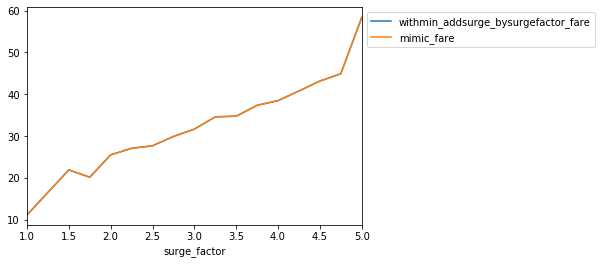

In [8]:
which = 0
additive_by_surge = find_parameters_for_dataset(dfs[which], df_names[which])

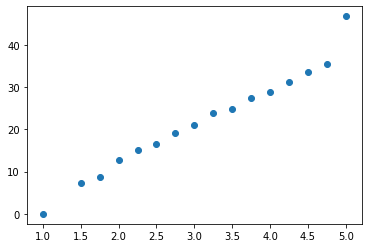

In [9]:
plt.scatter([x for x in additive_by_surge], [additive_by_surge[x]*(x-1) for x in additive_by_surge])

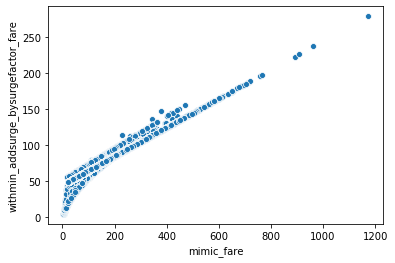

In [10]:
dfs[0] = withmin_additive_bysurgefactor(dfs[0])
sns.scatterplot(data= dfs[0], x = 'mimic_fare', y = 'withmin_addsurge_bysurgefactor_fare')